# Project 25: WordSense Disambiguation 1

The project consists in implementing a new scheme of wordsense disambiguation using Python NTLK, wordnet and supervised classification.
Consider the dataset senseval-2 (http://www.hipposmond.com/senseval2/) for training and testing tasks. This corpus consists of text from a mixture of places, including the British National Corpus and the Penn Treebank portion of the Wall Street Journal. Each word in the corpus is tagged with its part of speech, and the senses of the following target words are also manually annotated: the nouns interest, line; the verb serve and the adjective hard. The set of senses that are used to annotate each target word come from WordNet. You can list the set of target words for the senseval-2 corpus by running >>senseval.fileids()    with NLTK after importing the dataset or use the program given to you.

Study the program for wordsense disambiguation given in https://www.inf.ed.ac.uk/teaching/courses/fnlp/Tutorials/7_WSD/tutorial.html. The program would allow you to perform disambiguation task on senseeval-2 using Naives Bayes classifier on senseval-2 dataset. It also allows you to assess the performance of the disambiguation task using confusion matrix.

**Here, we have download the code from the given link and run in our environment.**

##Necessary Libraries

In [1]:
from __future__ import division
import nltk
nltk.download('senseval')
nltk.download('wordnet')
nltk.download('punkt')

import random
from nltk.corpus import senseval
from nltk.classify import accuracy, NaiveBayesClassifier, MaxentClassifier,DecisionTreeClassifier
from collections import defaultdict
import nltk.metrics.confusionmatrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random
import re
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

[nltk_data] Downloading package senseval to /root/nltk_data...
[nltk_data]   Package senseval is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##Reference Code proveide for the project.
we've made subtle changes as per our need keeping the logics same.

In [ ]:
# -*- coding: utf-8 -*-


# The following shows how the senseval corpus consists of instances, where each instance
# consists of a target word (and its tag), it position in the sentence it appeared in
# within the corpus (that position being word position, minus punctuation), and the context,
# which is the words in the sentence plus their tags.
#
# senseval.instances()[:1]
# [SensevalInstance(word='hard-a', position=20, context=[('``', '``'), ('he', 'PRP'),
# ('may', 'MD'), ('lose', 'VB'), ('all', 'DT'), ('popular', 'JJ'), ('support', 'NN'),
# (',', ','), ('but', 'CC'), ('someone', 'NN'), ('has', 'VBZ'), ('to', 'TO'),
# ('kill', 'VB'), ('him', 'PRP'), ('to', 'TO'), ('defeat', 'VB'), ('him', 'PRP'),
# ('and', 'CC'), ('that', 'DT'), ("'s", 'VBZ'), ('hard', 'JJ'), ('to', 'TO'), ('do', 'VB'),
# ('.', '.'), ("''", "''")], senses=('HARD1',))]
# update the code to use the senseval corpus in NLTK 3.0

def senses(word):
    """
    This takes a target word from senseval-2 (find out what the possible
    are by running senseval.fileides()), and it returns the list of possible
    senses for the word
    """
    return list(set(i.senses[0] for i in senseval.instances(word)))


# Both above and below, we depend on the (non-obvious?) fact that although the field is
#  called 'senses', there is always only 1, i.e. there is no residual ambiguity in the
#  data as we have it

def sense_instances(instances, sense):
    """
    This returns the list of instances in instances that have the sense sense
    """
    return [instance for instance in instances if instance.senses[0] == sense]


# >>> sense3 = sense_instances(senseval.instances('hard.pos'), 'HARD3')
# >>> sense3[:2]
# [SensevalInstance(word='hard-a', position=15,
#  context=[('my', 'PRP$'), ('companion', 'NN'), ('enjoyed', 'VBD'), ('a', 'DT'), ('healthy', 'JJ'), ('slice', 'NN'), ('of', 'IN'), ('the', 'DT'), ('chocolate', 'NN'), ('mousse', 'NN'), ('cake', 'NN'), (',', ','), ('made', 'VBN'), ('with', 'IN'), ('a', 'DT'), ('hard', 'JJ'), ('chocolate', 'NN'), ('crust', 'NN'), (',', ','), ('topping', 'VBG'), ('a', 'DT'), ('sponge', 'NN'), ('cake', 'NN'), ('with', 'IN'), ('either', 'DT'), ('strawberry', 'NN'), ('or', 'CC'), ('raspberry', 'JJ'), ('on', 'IN'), ('the', 'DT'), ('bottom', 'NN'), ('.', '.')],
#  senses=('HARD3',)),
#  SensevalInstance(word='hard-a', position=5,
#  context=[('``', '``'), ('i', 'PRP'), ('feel', 'VBP'), ('that', 'IN'), ('the', 'DT'), ('hard', 'JJ'), ('court', 'NN'), ('is', 'VBZ'), ('my', 'PRP$'), ('best', 'JJS'), ('surface', 'NN'), ('overall', 'JJ'), (',', ','), ('"', '"'), ('courier', 'NNP'), ('said', 'VBD'), ('.', '.')],
# senses=('HARD3',))]


_inst_cache = {}

STOPWORDS = ['.', ',', '?', '"', '``', "''", "'", '--', '-', ':', ';', '(',
             ')', '$', '000', '1', '2', '10,' 'I', 'i', 'a', 'about', 'after', 'all', 'also', 'an', 'any',
             'are', 'as', 'at', 'and', 'be', 'being', 'because', 'been', 'but', 'by',
             'can', "'d", 'did', 'do', "don'", 'don', 'for', 'from', 'had', 'has', 'have', 'he',
             'her', 'him', 'his', 'how', 'if', 'is', 'in', 'it', 'its', "'ll", "'m", 'me',
             'more', 'my', 'n', 'no', 'not', 'of', 'on', 'one', 'or', "'re", "'s", "s",
             'said', 'say', 'says', 'she', 'so', 'some', 'such', "'t", 'than', 'that', 'the',
             'them', 'they', 'their', 'there', 'this', 'to', 'up', 'us', "'ve", 'was', 'we', 'were',
             'what', 'when', 'where', 'which', 'who', 'will', 'with', 'years', 'you',
             'your']

STOPWORDS_SET = set(STOPWORDS)

NO_STOPWORDS = []


def wsd_context_features(instance, vocab, dist=3):
    features = {}
    ind = instance.position
    con = instance.context
    for i in range(max(0, ind - dist), ind):
        j = ind - i
        features['left-context-word-%s(%s)' % (j, con[i][0])] = True

    for i in range(ind + 1, min(ind + dist + 1, len(con))):
        j = i - ind
        features['right-context-word-%s(%s)' % (j, con[i][0])] = True

    features['word'] = instance.word
    #print(features['word'])
    features['pos'] = con[1][1]
    return features


def wsd_word_features(instance, vocab, dist=3):
    """
    Create a featureset where every key returns False unless it occurs in the
    instance's context
    """
    features = defaultdict(lambda: False)
    features['alwayson'] = True
    # cur_words = [w for (w, pos) in i.context]
    try:
        for (w, pos) in instance.context:
            if w in vocab:
                features[w] = True
    except ValueError:
        pass
    #print(features)
    return features


def extract_vocab_frequency(instances, stopwords=STOPWORDS_SET, n=300):
    """
    Given a list of senseval instances, return a list of the n most frequent words that
    appears in its context (i.e., the sentence with the target word in), output is in order
    of frequency and includes also the number of instances in which that key appears in the
    context of instances.
    """
    fd = nltk.FreqDist()
    for i in instances:
        (target, suffix) = i.word.split('-')
        words = (c[0] for c in i.context if not c[0] == target)
        for word in set(words) - set(stopwords):
            fd[word] += 1
            # for sense in i.senses:
            # cfd[sense][word] += 1
    return fd.most_common()[:n + 1]


def extract_vocab(instances, stopwords=STOPWORDS_SET, n=300):
    return [w for w, f in extract_vocab_frequency(instances, stopwords, n)]


##def wst_classifier(trainer, word, features,number=300):
##    print "Reading data..."
##    global _inst_cache
##    if word not in _inst_cache:
##        _inst_cache[word] = [(i, i.senses[0]) for i in senseval.instances(word)]
##    events = _inst_cache[word][:]
##    senses = list(set(l for (i, l) in events))
##    instances = [i for (i, l) in events]
##    vocab = extract_vocab(instances, n=number)
##    print ' Senses: ' + ' '.join(senses)
##
##    # Split the instances into a training and test set,
##    #if n > len(events): n = len(events)
##    n = len(events)
##    random.seed(5444522)
##    random.shuffle(events)
##    training_data = events[:int(0.8 * n)]
##    test_data = events[int(0.8 * n):n]
##    # Train classifier
##    print 'Training classifier...'
##    classifier = trainer([(features(i, vocab), label) for (i, label) in training_data])
##    # Test classifier
##    print 'Testing classifier...'
##    acc = accuracy(classifier, [(features(i, vocab), label) for (i, label) in test_data] )
##    print 'Accuracy: %6.4f' % acc

## ----> added train_percentage parameter to dynamically adjust the percentage
## ----> added cm.evaluate() for f1, precision, recall

def wst_classifier(trainer, word, features, stopwords_list=STOPWORDS_SET, number=300, log=False, distance=3,
                   confusion_matrix=False, train_percentage = 0.8, kpi = False):
    """
    This function takes as arguments:
        a trainer (e.g., NaiveBayesClassifier.train);
        a target word from senseval2 (you can find these out with senseval.fileids(),
            and they are 'hard.pos', 'interest.pos', 'line.pos' and 'serve.pos');
        a feature set (this can be wsd_context_features or wsd_word_features);
        a number (defaults to 300), which determines for wsd_word_features the number of
            most frequent words within the context of a given sense that you use to classify examples;
        a distance (defaults to 3) which determines the size of the window for wsd_context_features (if distance=3, then
            wsd_context_features gives 3 words and tags to the left and 3 words and tags to
            the right of the target word);
        log (defaults to false), which if set to True outputs the errors into a file errors.txt
        confusion_matrix (defaults to False), which if set to True prints a confusion matrix.

    Calling this function splits the senseval data for the word into a training set and a test set (the way it does
    this is the same for each call of this function, because the argument to random.seed is specified,
    but removing this argument would make the training and testing sets different each time you build a classifier).

    It then trains the trainer on the training set to create a classifier that performs WSD on the word,
    using features (with number or distance where relevant).

    It then tests the classifier on the test set, and prints its accuracy on that set.

    If log==True, then the errors of the classifier over the test set are written to errors.txt.
    For each error four things are recorded: (i) the example number within the test data (this is simply the index of the
    example within the list test_data); (ii) the sentence that the target word appeared in, (iii) the
    (incorrect) derived label, and (iv) the gold label.

    If confusion_matrix==True, then calling this function prints out a confusion matrix, where each cell [i,j]
    indicates how often label j was predicted when the correct label was i (so the diagonal entries indicate labels
    that were correctly predicted).
    """
    print("Reading data...")
    global _inst_cache

    """
      # comments for understanding

      1. senseval dataset contains example use of words in different contexts
      2. it has only few words hard line etc
      3. here we take instance of a word (hard) from senseval and create list of
       all context sentences in events list
      4. so for ML training, events is our dataset generated from senseval

    """

    if word not in _inst_cache:
        _inst_cache[word] = [(i, i.senses[0]) for i in senseval.instances(word)]
    events = _inst_cache[word][:]
    senses = list(set(l for (i, l) in events))
    instances = [i for (i, l) in events]
    vocab = extract_vocab(instances, stopwords=stopwords_list, n=number)
    print
    ' Senses: ' + ' '.join(senses)

    """
      # comments for understanding

      1. here we split the events dataset into test and train
      2.

    """
    # Split the instances into a training and test set,
    # if n > len(events): n = len(events)
    n = len(events)
    random.seed(5444522)
    random.shuffle(events)
    training_data = events[:int(train_percentage * n)]
    test_data = events[int(train_percentage * n):n]
    # Train classifier
    print('Training classifier...')
    classifier = trainer([(features(i, vocab, distance), label) for (i, label) in training_data])
    # Test classifier
    print('Testing classifier...')
    acc = accuracy(classifier, [(features(i, vocab, distance), label) for (i, label) in test_data])
    print('Accuracy: %6.4f' % acc)

    if log == True:
        # write error file
        print('Writing errors to errors.txt')

        output_error_file = open('errors.txt', 'w')
        errors = []
        for (i, label) in test_data:
            guess = classifier.classify(features(i, vocab, distance))
            if guess != label:
                con = i.context
                position = i.position
                item_number = str(test_data.index((i, label)))
                word_list = []
                for (word, tag) in con:
                    word_list.append(word)
                hard_highlighted = word_list[position].upper()
                word_list_highlighted = word_list[0:position] + [hard_highlighted] + word_list[position + 1:]
                sentence = ' '.join(word_list_highlighted)
                errors.append([item_number, sentence, guess, label])
        error_number = len(errors)
        output_error_file.write('There are ' + str(error_number) + ' errors!' + '\n' + '----------------------------' +
                                '\n' + '\n')
        for error in errors:
            output_error_file.write(str(errors.index(error) + 1) + ') ' + 'example number: ' + error[0] + '\n' +
                                    '    sentence: ' + error[1] + '\n' +
                                    '    guess: ' + error[2] + ';  label: ' + error[3] + '\n' + '\n')
        output_error_file.close()
    if confusion_matrix == True:
        gold = [label for (i, label) in test_data]
        derived = [classifier.classify(features(i, vocab)) for (i, label) in test_data]
        cm = nltk.ConfusionMatrix(gold, derived)
        if kpi==True:
            print(cm.evaluate())

        print(cm)
        return cm



def demo(trainer=NaiveBayesClassifier.train):
    print("NB, with features based on 300 most frequent context words")
    train = wst_classifier(trainer, 'hard.pos', wsd_word_features,log= True)
    print('-------')
    print("NB, with features based word + pos in 6 word window")
    wst_classifier(trainer, 'hard.pos', wsd_context_features)
##    print "MaxEnt, with features based word + pos in 6 word window"
##    wst_classifier(MaxentClassifier.train, 'hard.pos', wsd_context_features)
    return train

demo()

# Frequency Baseline
##hard_sense_fd = nltk.FreqDist([i.senses[0] for i in senseval.instances('hard.pos')])
##most_frequent_hard_sense= hard_sense_fd.keys()[0]
##frequency_hard_sense_baseline = hard_sense_fd.freq(hard_sense_fd.keys()[0])

##>>> frequency_hard_sense_baseline
##0.79736902838679902

NB, with features based on 300 most frequent context words
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8593
Writing errors to errors.txt
-------
NB, with features based word + pos in 6 word window
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8950


##Task 1

1.Comprehend the code, Test the program and Make sure it is working correctly in your configuration. Try to test various choice of pre-processing (with or without stopword, stemming), choice of the proportion of training and testing data employed and report the impact on the confusion matrix.

exploring the code based on the task 1 with several cases. For ex: with or without preprocessing, with word/context features. different train test prcentages.

In [ ]:
print("No Pre-processing (word_features): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_word_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,kpi = True)
print('--------------------')
print("No Pre-processing (context_features): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_context_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,kpi = True)

No Pre-processing (word_features): 
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8558
  Tag | Prec.  | Recall | F-measure
------+--------+--------+-----------
HARD1 | 0.8693 | 0.9758 | 0.9195
HARD2 | 0.6923 | 0.5114 | 0.5882
HARD3 | 0.8571 | 0.1558 | 0.2637

      |   H   H   H |
      |   A   A   A |
      |   R   R   R |
      |   D   D   D |
      |   1   2   3 |
------+-------------+
HARD1 |<685> 15   2 |
HARD2 |  43 <45>  . |
HARD3 |  60   5 <12>|
------+-------------+
(row = reference; col = test)

--------------------
No Pre-processing (context_features): 
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8950
  Tag | Prec.  | Recall | F-measure
------+--------+--------+-----------
HARD1 | 0.9832 | 0.9160 | 0.9484
HARD2 | 0.5887 | 0.8295 | 0.6887
HARD3 | 0.6742 | 0.7792 | 0.7229

      |   H   H   H |
      |   A   A   A |
      |   R   R   R |
      |   D   D   D |
      |   1   2   3 |
------+-------------+
HARD1 |<643> 39  20

<ConfusionMatrix: 776/867 correct>

In [ ]:
from nltk.stem import PorterStemmer
import re
pattern = re.compile(r'[^A-Za-z0-9]+')

stemmer = PorterStemmer()

"""
    this def takes the instance and
    make stem of each words
"""
def wsd_word_features_processed(instance, vocab, dist=3):
    features = defaultdict(lambda: False)
    features['alwayson'] = True
    try:
        for (w, pos) in instance.context:
            # Apply stemming to the word
            stemmed_word = stemmer.stem(w)
            # Remove symbols and special characters
            cleaned_word = re.sub(pattern, '', stemmed_word)
            #print(cleaned_word)
            if cleaned_word in vocab:
                features[cleaned_word] = True
    except ValueError:
        pass
    # print(features)
    return features


"""
   removes special characters and stem each token of the instance
"""
def wsd_context_features_processed(instance, vocab, dist=3):
    features = {}
    ind = instance.position
    con = instance.context
    for i in range(max(0, ind - dist), ind):
        j = ind - i
        # Apply stemming and remove symbols
        stemmed_word = stemmer.stem(con[i][0])
        cleaned_word = re.sub(pattern, '', stemmed_word)
        features['left-context-word-%s(%s)' % (j, cleaned_word)] = True

    for i in range(ind + 1, min(ind + dist + 1, len(con))):
        j = i - ind
        # Apply stemming and remove symbols
        stemmed_word = stemmer.stem(con[i][0])
        cleaned_word = re.sub(pattern, '', stemmed_word)
        features['right-context-word-%s(%s)' % (j, cleaned_word)] = True

    # Apply stemming to the instance word
    stemmed_word = stemmer.stem(instance.word)
    cleaned_word = re.sub(pattern, '', stemmed_word)

    features['word'] = cleaned_word
    features['pos'] = con[1][1]
    return features


print("Pre_processed (Stemming & With stopwords) word_features NB:")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_word_features_processed, confusion_matrix = True,stopwords_list=NO_STOPWORDS,number = 1000, kpi = True)

print("Pre_processed (Stemming & Without stopwords) word_features:")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_word_features_processed, confusion_matrix = True,stopwords_list=STOPWORDS, number = 400, kpi = True)


print('--------------------')

print("Pre-processed (context_features) NB:")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_context_features_processed, confusion_matrix = True,stopwords_list=STOPWORDS, kpi = True)


Pre_processed (Stemming & With stopwords) word_features NB:
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8743
  Tag | Prec.  | Recall | F-measure
------+--------+--------+-----------
HARD1 | 0.9147 | 0.9473 | 0.9307
HARD2 | 0.6105 | 0.6591 | 0.6339
HARD3 | 0.7778 | 0.4545 | 0.5738

      |   H   H   H |
      |   A   A   A |
      |   R   R   R |
      |   D   D   D |
      |   1   2   3 |
------+-------------+
HARD1 |<665> 29   8 |
HARD2 |  28 <58>  2 |
HARD3 |  34   8 <35>|
------+-------------+
(row = reference; col = test)

Pre_processed (Stemming & Without stopwords) word_features:
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8570
  Tag | Prec.  | Recall | F-measure
------+--------+--------+-----------
HARD1 | 0.8799 | 0.9601 | 0.9183
HARD2 | 0.6471 | 0.5000 | 0.5641
HARD3 | 0.7576 | 0.3247 | 0.4545

      |   H   H   H |
      |   A   A   A |
      |   R   R   R |
      |   D   D   D |
      |   1   2   3 |
------+----------

<ConfusionMatrix: 781/867 correct>

##Train test ratio variation

In [ ]:
#train test ratio 70/30
print("train test ratio 70/30")
print("No Pre-processing (word_features): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_word_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,train_percentage = 0.7)

print('--------------------')

print("Pre-processing(word_features): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_word_features_processed, stopwords_list=STOPWORDS, confusion_matrix = True, train_percentage = 0.7)

print('--------------------')


print("No Pre-processing (context_features): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_context_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,train_percentage = 0.7)

print('--------------------')

print("Pre-processing(context_features): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_context_features_processed, stopwords_list=STOPWORDS, confusion_matrix = True, train_percentage = 0.7)

train test ratio 70/30
No Pre-processing (word_features): 
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8554
      |    H    H    H |
      |    A    A    A |
      |    R    R    R |
      |    D    D    D |
      |    1    2    3 |
------+----------------+
HARD1 |<1028>  26    2 |
HARD2 |   67  <69>   . |
HARD3 |   82   11  <15>|
------+----------------+
(row = reference; col = test)

--------------------
Pre-processing(word_features): 
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8492
      |    H    H    H |
      |    A    A    A |
      |    R    R    R |
      |    D    D    D |
      |    1    2    3 |
------+----------------+
HARD1 |<1006>  41    9 |
HARD2 |   69  <66>   1 |
HARD3 |   71    5  <32>|
------+----------------+
(row = reference; col = test)

--------------------
No Pre-processing (context_features): 
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8869
      |   H   H   H |
      |   

<ConfusionMatrix: 1166/1300 correct>

In [ ]:
#train test ratio 60/40

print("train test ratio 60/40")
print("No Pre-processing (word_features): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_word_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,train_percentage = 0.6)

print('--------------------')

print("Pre-processing(word_features): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_word_features_processed, stopwords_list=STOPWORDS, confusion_matrix = True, train_percentage = 0.6)

print('--------------------')


print("No Pre-processing (context_features): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_context_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,train_percentage = 0.6)

print('--------------------')

print("Pre-processing(context_features): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_context_features_processed, stopwords_list=STOPWORDS, confusion_matrix = True, train_percentage = 0.6)

train test ratio 60/40
No Pre-processing (word_features): 
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8512
      |    H    H    H |
      |    A    A    A |
      |    R    R    R |
      |    D    D    D |
      |    1    2    3 |
------+----------------+
HARD1 |<1358>  39    6 |
HARD2 |   82  <96>   . |
HARD3 |  115   16  <22>|
------+----------------+
(row = reference; col = test)

--------------------
Pre-processing(word_features): 
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8391
      |    H    H    H |
      |    A    A    A |
      |    R    R    R |
      |    D    D    D |
      |    1    2    3 |
------+----------------+
HARD1 |<1326>  59   18 |
HARD2 |   91  <86>   1 |
HARD3 |  100   10  <43>|
------+----------------+
(row = reference; col = test)

--------------------
No Pre-processing (context_features): 
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8725
      |    H    H    H |
      |

<ConfusionMatrix: 1526/1734 correct>

## Task 2: Add into the program other performance metric (accuracy, F1 score, precision and recall).

In [ ]:
#for prec, recall, f-score pass "kpi=True"

print("No Pre-processing word_feature (HARD): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_word_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS, kpi = True)

print('--------------------')

print("Without Stopwords(HARD): ")
wst_classifier(NaiveBayesClassifier.train, 'hard.pos', wsd_word_features, stopwords_list=STOPWORDS, confusion_matrix = True, number = 500, kpi = True)


No Pre-processing (HARD): 
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8558
  Tag | Prec.  | Recall | F-measure
------+--------+--------+-----------
HARD1 | 0.8693 | 0.9758 | 0.9195
HARD2 | 0.6923 | 0.5114 | 0.5882
HARD3 | 0.8571 | 0.1558 | 0.2637

      |   H   H   H |
      |   A   A   A |
      |   R   R   R |
      |   D   D   D |
      |   1   2   3 |
------+-------------+
HARD1 |<685> 15   2 |
HARD2 |  43 <45>  . |
HARD3 |  60   5 <12>|
------+-------------+
(row = reference; col = test)

--------------------
Without Stopwords(HARD): 
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8604
  Tag | Prec.  | Recall | F-measure
------+--------+--------+-----------
HARD1 | 0.8965 | 0.9501 | 0.9225
HARD2 | 0.5904 | 0.5568 | 0.5731
HARD3 | 0.7500 | 0.3896 | 0.5128

      |   H   H   H |
      |   A   A   A |
      |   R   R   R |
      |   D   D   D |
      |   1   2   3 |
------+-------------+
HARD1 |<667> 26   9 |
HARD2 |  38 <49>  1

<ConfusionMatrix: 746/867 correct>

##Task 3 & 4
we merged task 3 & 4 togather, we run the program with decesion tree, svm and random forest with/without processing.

In [ ]:
#train with decision tree

print('Train with DT (word_fratures) no preprocessing:')
wst_classifier(DecisionTreeClassifier.train, 'hard.pos', wsd_word_features, confusion_matrix=True, kpi=True, stopwords_list=NO_STOPWORDS)
print('######')
print('Train with DT (word_fratures) with preprocessing:')
wst_classifier(DecisionTreeClassifier.train, 'hard.pos', wsd_word_features_processed, confusion_matrix=True, kpi=True)

print('--------------------')
print('Train with DT (context_fratures):')
wst_classifier(DecisionTreeClassifier.train, 'hard.pos', wsd_context_features_processed, confusion_matrix=True, kpi=True)

print('--------------------')
print('Train with DT (context_fratures):')
wst_classifier(DecisionTreeClassifier.train, 'hard.pos', wsd_context_features, confusion_matrix=True, kpi=True,stopwords_list=NO_STOPWORDS)


Train with DT (word_fratures) no preprocessing:
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8466
  Tag | Prec.  | Recall | F-measure
------+--------+--------+-----------
HARD1 | 0.8609 | 0.9701 | 0.9123
HARD2 | 0.7000 | 0.4773 | 0.5676
HARD3 | 0.6875 | 0.1429 | 0.2366

      |   H   H   H |
      |   A   A   A |
      |   R   R   R |
      |   D   D   D |
      |   1   2   3 |
------+-------------+
HARD1 |<681> 17   4 |
HARD2 |  45 <42>  1 |
HARD3 |  65   1 <11>|
------+-------------+
(row = reference; col = test)

######
Train with DT (word_fratures) with preprocessing:
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.8627
  Tag | Prec.  | Recall | F-measure
------+--------+--------+-----------
HARD1 | 0.8707 | 0.9786 | 0.9215
HARD2 | 0.8261 | 0.4318 | 0.5672
HARD3 | 0.7188 | 0.2987 | 0.4220

      |   H   H   H |
      |   A   A   A |
      |   R   R   R |
      |   D   D   D |
      |   1   2   3 |
------+-------------+
HARD1 |<68

<ConfusionMatrix: 803/867 correct>

In [ ]:
print('--------------------')
print('Train with DT (context_fratures) no processing:')
wst_classifier(DecisionTreeClassifier.train, 'hard.pos', wsd_context_features, confusion_matrix=True, kpi=True,stopwords_list=NO_STOPWORDS)

--------------------
Train with DT (context_fratures) no processing:
Reading data...
Training classifier...
Testing classifier...
Accuracy: 0.9170
  Tag | Prec.  | Recall | F-measure
------+--------+--------+-----------
HARD1 | 0.9183 | 0.9929 | 0.9541
HARD2 | 0.9483 | 0.6250 | 0.7534
HARD3 | 0.8600 | 0.5584 | 0.6772

      |   H   H   H |
      |   A   A   A |
      |   R   R   R |
      |   D   D   D |
      |   1   2   3 |
------+-------------+
HARD1 |<697>  1   4 |
HARD2 |  30 <55>  3 |
HARD3 |  32   2 <43>|
------+-------------+
(row = reference; col = test)



<ConfusionMatrix: 795/867 correct>

In [ ]:
from sklearn.metrics import classification_report
from itertools import cycle
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
"""
we modified the wst_classifier, it works fine with the classifiers in nltk libarary,
but random forest and svm is not available in nltk libarary. So, we used sklearn library.
In order to use sklearn some changes were made, to run the svm and random forest.
"""



def wst_classifier_mod(trainer, word, features, classifier_type, stopwords_list=STOPWORDS_SET, number=300, log=False, distance=3,
                   confusion_matrix=False, train_percentage=0.8):

    print("Reading data...")
    global _inst_cache
    if word not in _inst_cache:
        _inst_cache[word] = [(i, i.senses[0]) for i in senseval.instances(word)]
    events = _inst_cache[word][:]
    senses = list(set(l for (i, l) in events))
    instances = [i for (i, l) in events]
    vocab = extract_vocab(instances, stopwords=stopwords_list, n=number)
    print('Senses: ' + ' '.join(senses))

    # Split the instances into a training and test set
    n = len(events)
    random.seed(5444522)
    random.shuffle(events)
    training_data = events[:int(train_percentage * n)]
    test_data = events[int(train_percentage * n):n]

    if classifier_type == 'nb':
        # Train and test using Naive Bayes classifier
        classifier = trainer([(features(i, vocab, distance), label) for (i, label) in training_data])
    elif classifier_type == 'svm':
        # Train and test using Support Vector Machine (SVM) classifier
        print('Training classifier...')
        vectorizer = DictVectorizer()

        X_train = vectorizer.fit_transform([features(i, vocab, distance) for (i, label) in training_data])
        #print(f'X_train: {X_train}')
        y_train = [label for (i, label) in training_data]
        #print(f'y_train: {y_train}')
        classifier = SVC()
        classifier.fit(X_train, y_train)
    elif classifier_type == 'rf':
        # Train and test using Random Forest classifier
        print('Training classifier...')
        vectorizer = DictVectorizer()
        X_train = vectorizer.fit_transform([features(i, vocab, distance) for (i, label) in training_data])
        y_train = [label for (i, label) in training_data]
        classifier = RandomForestClassifier()
        classifier.fit(X_train, y_train)
    else:
        raise ValueError("Invalid classifier_type. Use 'nb' for Naive Bayes, 'svm' for SVM, or 'rf' for Random Forest")

    # Test classifier
    print('Testing classifier...')
    if classifier_type == 'nb':
        acc = accuracy_score([label for (i, label) in test_data],
                             [classifier.classify(features(i, vocab, distance)) for (i, label) in test_data])
    else:
        X_test = vectorizer.transform([features(i, vocab, distance) for (i, label) in test_data])

        y_test = [label for (i, label) in test_data]
        acc = classifier.score(X_test, y_test)
        y_pred = classifier.predict(X_test)
        print(classification_report(y_test, y_pred, labels=["HARD1", "HARD2", "HARD3"]))
    print('Accuracy: %6.4f' % acc)

    if log == True:
        # write error file
        print('Writing errors to errors.txt')

        output_error_file = open('errors.txt', 'w')
        errors = []
        for (i, label) in test_data:
            guess = classifier.classify(features(i, vocab, distance))
            if guess != label:
                con = i.context
                position = i.position
                item_number = str(test_data.index((i, label)))
                word_list = []
                for (word, tag) in con:
                    word_list.append(word)
                hard_highlighted = word_list[position].upper()
                word_list_highlighted = word_list[0:position] + [hard_highlighted] + word_list[position + 1:]
                sentence = ' '.join(word_list_highlighted)
                errors.append([item_number, sentence, guess, label])
        error_number = len(errors)
        output_error_file.write('There are ' + str(error_number) + ' errors!' + '\n' + '----------------------------' +
                                '\n' + '\n')
        for error in errors:
            output_error_file.write(str(errors.index(error) + 1) + ') ' + 'example number: ' + error[0] + '\n' +
                                    '    sentence: ' + error[1] + '\n' +
                                    '    guess: ' + error[2] + ';  label: ' + error[3] + '\n' + '\n')
        output_error_file.close()

    c_m = None
    if confusion_matrix == True:
        if classifier_type == 'nb':
            gold = [label for (i, label) in test_data]
            derived = [classifier.classify(features(i, vocab, distance)) for (i, label) in test_data]
            c_m = nltk.ConfusionMatrix(gold, derived)
            print(c_m)
        else:
            print("Confusion Matrix:")
            ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)
            plt.show()


      #############

      #############

    return c_m

Train with SVM, No preprocessing(word_freatures):
Reading data...
Senses: HARD2 HARD3 HARD1
Training classifier...
Testing classifier...
              precision    recall  f1-score   support

       HARD1       0.89      0.99      0.94       702
       HARD2       0.89      0.47      0.61        88
       HARD3       0.94      0.42      0.58        77

    accuracy                           0.89       867
   macro avg       0.91      0.62      0.71       867
weighted avg       0.89      0.89      0.87       867

Accuracy: 0.8881
Confusion Matrix:


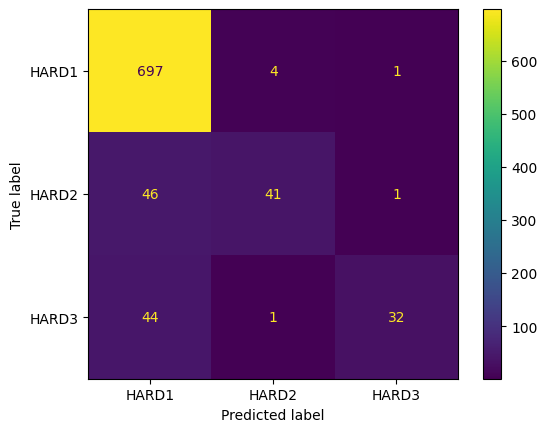

Train with SVM,No preprocessing (context_freatures):
Reading data...
Senses: HARD2 HARD3 HARD1
Training classifier...
Testing classifier...
              precision    recall  f1-score   support

       HARD1       0.91      1.00      0.95       702
       HARD2       0.98      0.58      0.73        88
       HARD3       0.84      0.48      0.61        77

    accuracy                           0.91       867
   macro avg       0.91      0.69      0.76       867
weighted avg       0.91      0.91      0.90       867

Accuracy: 0.9100
Confusion Matrix:


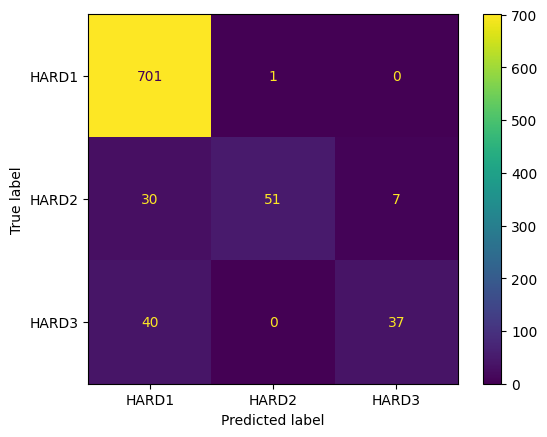

--------------------------------------
Train with Random Forest, No preprocessing (word_freatures):
Reading data...
Senses: HARD2 HARD3 HARD1
Training classifier...
Testing classifier...
              precision    recall  f1-score   support

       HARD1       0.89      0.99      0.94       702
       HARD2       0.92      0.50      0.65        88
       HARD3       0.83      0.44      0.58        77

    accuracy                           0.89       867
   macro avg       0.88      0.64      0.72       867
weighted avg       0.89      0.89      0.88       867

Accuracy: 0.8927
Confusion Matrix:


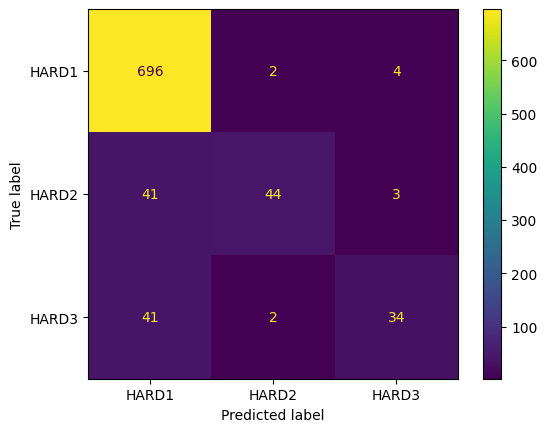

Train with Random Forest, No preprocessing (context_freatures):
Reading data...
Senses: HARD2 HARD3 HARD1
Training classifier...
Testing classifier...
              precision    recall  f1-score   support

       HARD1       0.91      1.00      0.95       702
       HARD2       0.93      0.65      0.77        88
       HARD3       0.94      0.40      0.56        77

    accuracy                           0.91       867
   macro avg       0.93      0.68      0.76       867
weighted avg       0.91      0.91      0.90       867

Accuracy: 0.9100
Confusion Matrix:


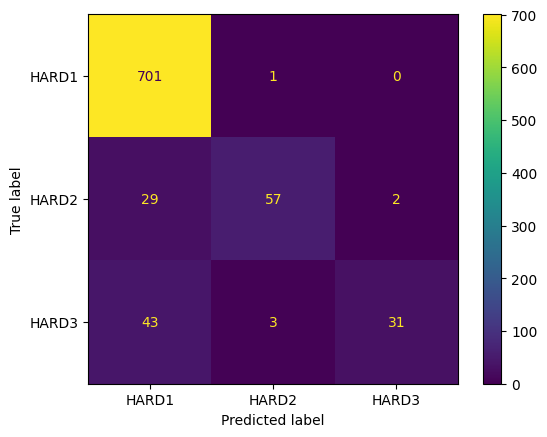

In [ ]:
#train with svm for the case No preprocessing (word and context features)
print('Train with SVM, No preprocessing(word_freatures):')
wst_classifier_mod(None,'hard.pos', wsd_word_features,'svm',confusion_matrix = True, number=500,stopwords_list=NO_STOPWORDS ) #0.8627

print('Train with SVM,No preprocessing (context_freatures):')
wst_classifier_mod(None,'hard.pos', wsd_context_features,'svm',confusion_matrix = True,stopwords_list=NO_STOPWORDS) #0.9100

print('--------------------------------------')

#train with random forest for the case No preprocessing (word and context features)
print('Train with Random Forest, No preprocessing (word_freatures):')
wst_classifier_mod(None,'hard.pos', wsd_word_features,'rf',confusion_matrix = True,number=500,stopwords_list=NO_STOPWORDS) #0.8489

print('Train with Random Forest, No preprocessing (context_freatures):')
wst_classifier_mod(None,'hard.pos', wsd_context_features,'rf',confusion_matrix = True,stopwords_list=NO_STOPWORDS) #0.9066

Train with SVM, with preprocessing(word_freatures):
Reading data...
Senses: HARD2 HARD3 HARD1
Training classifier...
Testing classifier...
              precision    recall  f1-score   support

       HARD1       0.86      0.98      0.91       702
       HARD2       0.78      0.40      0.53        88
       HARD3       0.75      0.19      0.31        77

    accuracy                           0.85       867
   macro avg       0.80      0.52      0.58       867
weighted avg       0.84      0.85      0.82       867

Accuracy: 0.8512
Confusion Matrix:


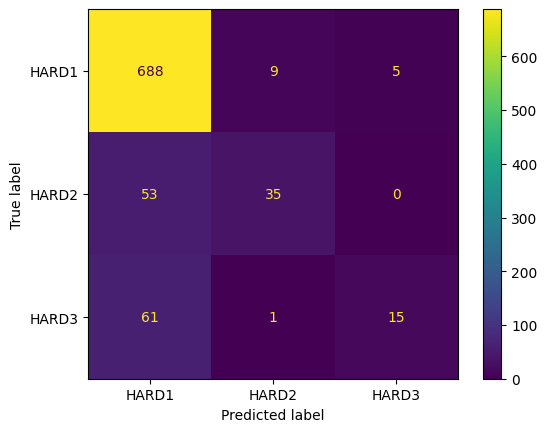

Train with SVM, with preprocessing (context_freatures):
Reading data...
Senses: HARD2 HARD3 HARD1
Training classifier...
Testing classifier...
              precision    recall  f1-score   support

       HARD1       0.91      1.00      0.95       702
       HARD2       0.93      0.61      0.74        88
       HARD3       0.86      0.49      0.63        77

    accuracy                           0.91       867
   macro avg       0.90      0.70      0.77       867
weighted avg       0.91      0.91      0.90       867

Accuracy: 0.9123
Confusion Matrix:


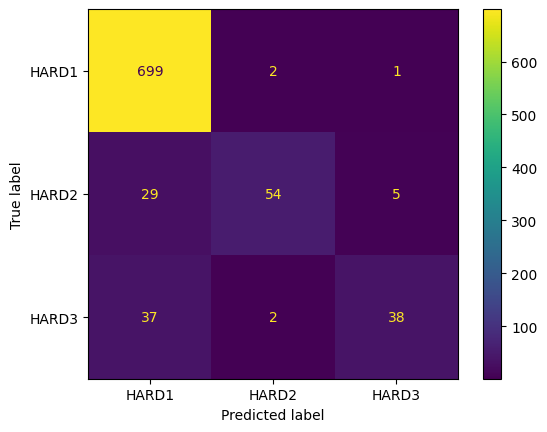

--------------------------------------
Train with Random Forest, with preprocessing (word_freatures):
Reading data...
Senses: HARD2 HARD3 HARD1
Training classifier...
Testing classifier...
              precision    recall  f1-score   support

       HARD1       0.88      0.94      0.91       702
       HARD2       0.61      0.50      0.55        88
       HARD3       0.58      0.38      0.46        77

    accuracy                           0.84       867
   macro avg       0.69      0.60      0.64       867
weighted avg       0.83      0.84      0.83       867

Accuracy: 0.8431
Confusion Matrix:


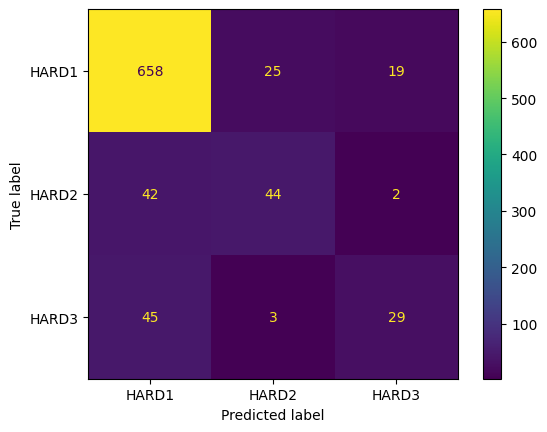

Train with Random Forest, with preprocessing (context_freatures):
Reading data...
Senses: HARD2 HARD3 HARD1
Training classifier...
Testing classifier...
              precision    recall  f1-score   support

       HARD1       0.91      1.00      0.95       702
       HARD2       0.92      0.66      0.77        88
       HARD3       0.95      0.45      0.61        77

    accuracy                           0.91       867
   macro avg       0.93      0.70      0.78       867
weighted avg       0.92      0.91      0.90       867

Accuracy: 0.9146
Confusion Matrix:


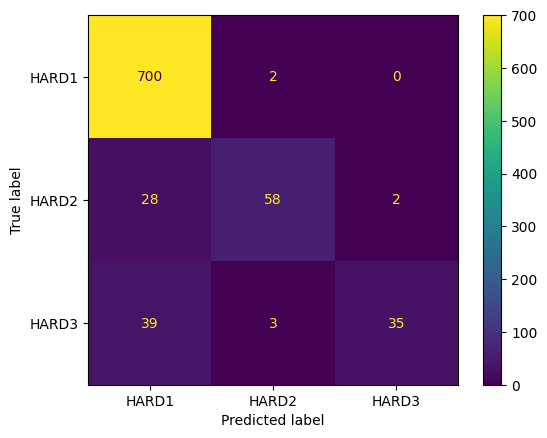

In [ ]:
#train with svm for the case with preprocessing (word and context features)
print('Train with SVM, with preprocessing(word_freatures):')
wst_classifier_mod(None,'hard.pos', wsd_word_features_processed,'svm',confusion_matrix = True, number=500) #0.8627

print('Train with SVM, with preprocessing (context_freatures):')
wst_classifier_mod(None,'hard.pos', wsd_context_features_processed,'svm',confusion_matrix = True) #0.9100

print('--------------------------------------')

#train with rf for the case with preprocessing (word and context features)
print('Train with Random Forest, with preprocessing (word_freatures):')
wst_classifier_mod(None,'hard.pos', wsd_word_features_processed,'rf',confusion_matrix = True,number=500) #0.8489

print('Train with Random Forest, with preprocessing (context_freatures):')
wst_classifier_mod(None,'hard.pos', wsd_context_features_processed,'rf',confusion_matrix = True) #0.9066

##Task 5
#### Test the influence of various features: Number of features employed, tf-idf, 2-gram. Provide a table where the performance of selected classifiers of the above classifiers were compared with respect to features (number and type) accordingly using the configuration of the preprocessing that yields best performance in 4)

In [2]:
# Defining the function for extracting the sentences and senses from the dataset, preprocessing
# and a TFIDF function which will convert the given data into tfidf vectors
STOPWORDS = ['.', ',', '?', '"', '``', "''", "'", '--', '-', ':', ';', '(',
             ')', '$', '000', '1', '2', '10,' 'I', 'i', 'a', 'about', 'after', 'all', 'also', 'an', 'any',
             'are', 'as', 'at', 'and', 'be', 'being', 'because', 'been', 'but', 'by',
             'can', "'d", 'did', 'do', "don'", 'don', 'for', 'from', 'had', 'has', 'have', 'he',
             'her', 'him', 'his', 'how', 'if', 'is', 'in', 'it', 'its', "'ll", "'m", 'me',
             'more', 'my', 'n', 'no', 'not', 'of', 'on', 'one', 'or', "'re", "'s", "s",
             'said', 'say', 'says', 'she', 'so', 'some', 'such', "'t", 'than', 'that', 'the',
             'them', 'they', 'their', 'there', 'this', 'to', 'up', 'us', "'ve", 'was', 'we', 'were',
             'what', 'when', 'where', 'which', 'who', 'will', 'with', 'years', 'you',
             'your']


def get_sentence_and_sense(word):
  sentences = []
  senses = []
  instances = senseval.instances(word)
  for i in range(len(instances)):
    inst = instances[i]
    sentence = ""
    for tup in inst.context:
      sentence += " "+tup[0]
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    sentence = sentence.strip()
    sentences.append(sentence)
    senses.append(inst.senses[0])
  return sentences, senses

# print(len(sentences))
# print(len(senses))


# Preprocess
def preProcess(doc):
    Stopwords = STOPWORDS
    porter = nltk.PorterStemmer()
    WN_lemmatizer = WordNetLemmatizer()

    sentences = sent_tokenize(doc)
    Tokens = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [porter.stem(word) for word in words]
        words = [WN_lemmatizer.lemmatize(word, pos="v") for word in words]

        words = [word for word in words if word.isalpha() and word not in Stopwords] #get rid of numbers and Stopwords
        #words= [word for word in words if word.isalnum() and word not in Stopwords]
        Tokens.extend(words)

    return ' '.join(Tokens)

def TFIDF(corpus, preprocess=None, ngram=(1,1)):
    Tfidf = TfidfVectorizer(preprocessor=preprocess,ngram_range=ngram)
    return Tfidf.fit_transform(corpus)


In [3]:
# calling the get_sentencd_and_sense function which will return the sentences and the senses
# calling the TFIDF function with the sentences, which will return the tfidf matrix of the sentenses
sentences, senses = get_sentence_and_sense('hard.pos')
# convertring the senses into neumeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(senses)
X = TFIDF(sentences, ngram=(1,2))   # here it takes two additional parameters "preprocessing" and "ngram"
print(X[:2])
print(y[:2])

  (0, 57838)	0.11717590892440401
  (0, 24222)	0.047969050646112184
  (0, 53307)	0.13626695794994167
  (0, 3824)	0.13983883959308796
  (0, 25663)	0.1957986225254393
  (0, 14789)	0.21890395325649564
  (0, 57782)	0.21890395325649564
  (0, 25708)	0.15327412215528946
  (0, 30479)	0.20867968153044555
  (0, 58053)	0.187314085862005
  (0, 24569)	0.17170429614334012
  (0, 49732)	0.21890395325649564
  (0, 9517)	0.21890395325649564
  (0, 51834)	0.21890395325649564
  (0, 42145)	0.20867968153044555
  (0, 2067)	0.21890395325649564
  (0, 32450)	0.21890395325649564
  (0, 33728)	0.21890395325649564
  (0, 24970)	0.1957986225254393
  (0, 15973)	0.10420574679927082
  (0, 23836)	0.02925204721048538
  (0, 53114)	0.05965489590573657
  (0, 2809)	0.04965965533418285
  (0, 14788)	0.21890395325649564
  (0, 25661)	0.23710335364766608
  :	:
  (1, 56282)	0.09329007097620459
  (1, 52326)	0.11245204650938016
  (1, 64000)	0.12503389427073078
  (1, 27821)	0.14068652563515374
  (1, 34354)	0.12940803338875495
  (1, 32590

In [4]:
# spliting the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# defining the classifiers
def svm(X_train, y_train):
  clf = SVC()
  clf.fit(X_train, y_train)
  return clf


def dt(X_train, y_train):
  dt = DecisionTreeClassifier()
  dt.fit()
  return dt


def rf(X_train, y_train):
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)
  return rf

In [6]:
# defining a function to calculate and report the performance of the classifiers
def performance_matrices(clf, X_test, y_test):
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy}")
  report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1, output_dict=True)
  print("Classification Report:")
  print(report)
  #df = pd.DataFrame(report).to_csv(f"{clf.__str__().replace('()','')}'_without_pre_1_2gram'.csv")

In [8]:
# training the classifiers with the train data
svc = svm(X_train, y_train)
#dt = dt(X_train, y_train)
rf = rf(X_train, y_train)

In [10]:
# displaying the performance of the classifiers on test data
performance_matrices(svc, X_test, y_test)
#performance_matrices(dt, X_test, y_test)
performance_matrices(rf, X_test, y_test)

Accuracy: 0.8362168396770473
Classification Report:
{'HARD1': {'precision': 0.8333333333333334, 'recall': 0.9971509971509972, 'f1-score': 0.9079118028534372, 'support': 702}, 'HARD2': {'precision': 0.9259259259259259, 'recall': 0.2717391304347826, 'f1-score': 0.42016806722689076, 'support': 92}, 'HARD3': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 73}, 'accuracy': 0.8362168396770473, 'macro avg': {'precision': 0.9197530864197532, 'recall': 0.4229633758619266, 'f1-score': 0.442693290026776, 'support': 867}, 'weighted avg': {'precision': 0.8571916784142851, 'recall': 0.8362168396770473, 'f1-score': 0.7797111277831452, 'support': 867}}
Accuracy: 0.8673587081891581
Classification Report:
{'HARD1': {'precision': 0.8638613861386139, 'recall': 0.9943019943019943, 'f1-score': 0.9245033112582781, 'support': 702}, 'HARD2': {'precision': 0.9019607843137255, 'recall': 0.5, 'f1-score': 0.6433566433566434, 'support': 92}, 'HARD3': {'precision': 1.0, 'recall': 0.1095890410958904, 'f

##Task 6
Use the Lesk implementation in NLTK   (>>from nltk.wsd import lesk), test for few examples of target words of seneval2 the result you will be getting using Lesk algorithm’s disambiguation and report the result of the disambiguation task on both training and testing dataset. Compare the result with Bayes’ classifier.

In [ ]:
from nltk.corpus import wordnet
from nltk.wsd import lesk

# Tokenize a sentence into words
sentence = "I saw a man with a telescope."
words = nltk.word_tokenize(sentence)

# Perform Lesk word sense disambiguation for a target word in context
target_word = "saw"
synset = lesk(words, target_word)

# Get the definition and examples of the chosen synset
if synset:
    definition = synset.definition()
    examples = synset.examples()
    print("Word:", target_word)
    print("Chosen Synset:", synset.name())
    print("Definition:", definition)
    print("Examples:", examples)



##Task 7
We want to expand the Lesk algorithm to include related terms. Start with NLTK WordNet examples to design and implement a program that extract for each sense of the target word, all the information in the synset (word itself, sense and example sentence (s)). Now expand for each term of the example sentence its direct hyponym, direct hypernym, antonym (if available) and any other related terms that can be extracted using WordNet entity relationship. Now construct a large set of each sense of target word that includes all the above. Then perform the simplified Lesk algorithm disambiguation methodology, e.g., count the number of common words between the created enlarged list of each sense and the set of words in the sentence to be disambiguated.

In [ ]:
#lesk v1


from nltk.corpus import wordnet
from nltk.corpus import stopwords


##########################################
def extend_sig(sig):
    lemma_names_set = set()
    stop_words = set(stopwords.words("english"))
    sig = sig - stop_words


    for term in sig:
        lemma_names_set.add(term)

        synsets = wordnet.synsets(term)

        # for each synset, find its hyponyms and hypernyms
        for synset in synsets:
            hyponyms_set = set()
            hypernyms_set = set()

            hyponyms_set.update(synset.hyponyms())
            hypernyms_set.update(synset.hypernyms())

            hyponyms_and_hypernyms_set = hyponyms_set.union(hypernyms_set)

            for synset in hyponyms_and_hypernyms_set:
                for lemma in synset.lemmas():
                    l = lemma.name().lower().replace('_', ' ').replace('-', ' ')

                    words = l.split()

                    lemma_names_set.update(words)

    # return extended signature
    return lemma_names_set

##########################################

"The exam was too hard for the studensts to pass"
'I am going to the bank with some money'

cotext_sentence = "The exam was too hard for the studensts to pass"
amb_word = "hard"

max_overlap = 0
lesk_sense = None
lesk_definition = ''
context_words = nltk.word_tokenize(cotext_sentence)
context_words = set(context_words)

for sense in wn.synsets(amb_word):
    print(f"sense: {sense}")
    signature = set()
    print(f"sense_definition: {sense.definition()}")
    sense_definitions = nltk.word_tokenize(sense.definition())
    signature = signature.union(set(sense_definitions))
    signature = signature.union(set(sense.lemma_names()))
    print(f"sense_examples: {sense.examples()}")
    for example in sense.examples():
        signature = signature.union(set(example.split()))
    print(f"base_signature_set: {signature}")
    signature = extend_sig(signature)
    print(f"extended_signature_set: {signature}")
    overlap  = len(context_words.intersection(signature))
    if overlap > max_overlap:
        lesk_sense = sense
        max_overlap = overlap
        lesk_definition = sense.definition()

print(f'sense in the senstence:{lesk_sense}')
print(f"definition: {lesk_definition}")

##Task 8


In [ ]:
print("No Pre-processing (word_features): ")
wst_classifier(NaiveBayesClassifier.train, 'line.pos', wsd_word_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,kpi = True)
print('--------------------')
print("No Pre-processing (context_features): ")
wst_classifier(NaiveBayesClassifier.train, 'line.pos', wsd_context_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,kpi = True)

In [ ]:
print("No Pre-processing (word_features): ")
wst_classifier(NaiveBayesClassifier.train, 'interest.pos', wsd_word_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,kpi = True)
print('--------------------')
print("No Pre-processing (context_features): ")
wst_classifier(NaiveBayesClassifier.train, 'interest.pos', wsd_context_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,kpi = True)

In [ ]:
print("No Pre-processing (word_features): ")
wst_classifier(NaiveBayesClassifier.train, 'serve.pos', wsd_word_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,kpi = True)
print('--------------------')
print("No Pre-processing (context_features): ")
wst_classifier(NaiveBayesClassifier.train, 'serve.pos', wsd_context_features, confusion_matrix = True,stopwords_list=NO_STOPWORDS,kpi = True)

##Experiments


In [ ]:
for inst in senseval.instances('hard.pos')[:20]:
     #p = inst.position
     left = '---'#.join(w for (w,t) in inst.context[p-2:p])
     word = '---'#.join(w for (w,t) in inst.context[p:p+1])
     right = '---'#.join(w for (w,t) in inst.context[p+1:p+3])
     sent = ' '.join(w for (w,t) in inst.context)
     senses = ' '.join(inst.senses)
     #print('%20s |%10s | %-15s - %s' % (left, word, sent, senses))
     print('%-15s - %s' % (sent, senses))


`` he may lose all popular support , but someone has to kill him to defeat him and that 's hard to do . '' - HARD1
clever white house `` spin doctors '' are having a hard time helping president bush explain away the economic bashing that low-and middle-income workers are taking these days . - HARD1
i find it hard to believe that the sacramento river will ever be quite the same , although i certainly wish that i 'm wrong . - HARD1
now when you get bad credit data or are confused with another person , the hard part in correcting the mistake is not even knowing where it is recorded , let alone having access . - HARD1
'a great share of responsibility for this national tragedy unquestionably lies with the president of the country . ' -- eduard shevardnadze , former foreign minister ; 'we are so deep in this crisis that all this business about leaving the party , not leaving the party -- that will never get us out . ' -- natasha , a moscow bookkeeper ; 'our life is harder now , yes , but it 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
np = pd.read_csv('np.csv')
wp = pd.read_csv('wp.csv')

np_word = np[np['feature_type'] == 'word']
np_context = np[np['feature_type'] == 'context']
np_tfidf = np[np['feature_type'] == 'tf-idf']

wp_word = wp[wp['feature_type'] == 'word']
wp_context = wp[wp['feature_type'] == 'context']
wp_tfidf = wp[wp['feature_type'] == 'tf-idf']



##Charts

In [ ]:
def plot_chart(data, title):
    sns.set_style("whitegrid")
    sns.set_palette("crest")

    # Set the figure size
    plt.figure(figsize=(7, 5))

    # Create subplots for 'Precision,' 'Recall,' 'F1,' and 'Accuracy'
    plt.subplot(2, 2, 1)
    sns.barplot(data=data, x='Classifier', y='Precision', hue='Tag', ci=None)
    plt.title('Precision', fontsize=8)  # Set the font size
    plt.legend(fontsize=9,loc='lower left')


    plt.subplot(2, 2, 2)
    sns.barplot(data=data, x='Classifier', y='Recall', hue='Tag', ci=None)
    plt.title('Recall', fontsize=8)  # Set the font size
    plt.legend(fontsize=9,loc='lower left')

    plt.subplot(2, 2, 3)
    sns.barplot(data=data, x='Classifier', y='F1', hue='Tag', ci=None)
    plt.title('F1', fontsize=8)  # Set the font size
    plt.legend(fontsize=9,loc='lower left')

    plt.subplot(2, 2, 4)
    sns.barplot(data=data, x='Classifier', y='Accuracy', ci=None)
    plt.title('Accuracy', fontsize=8)  # Set the font size
    plt.legend(fontsize=9)

    plt.suptitle(title, fontsize=12)  # Set the font size for the overall title


    plt.tight_layout()
    plt.show()

<ipython-input-82-f8da1395b033>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Precision', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Recall', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='F1', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Accuracy', ci=None)


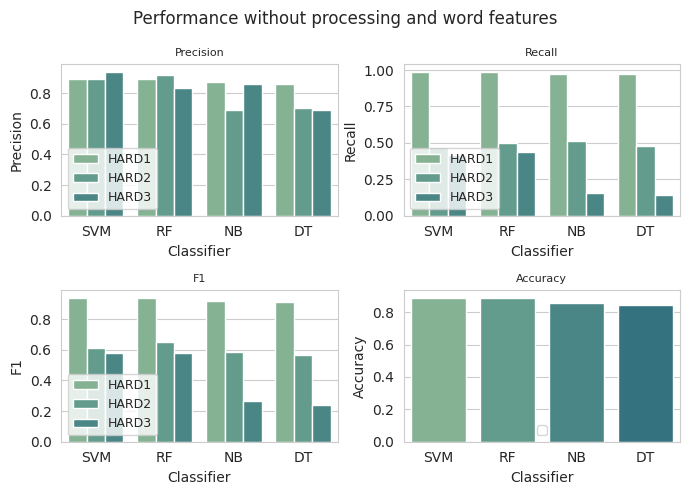

In [ ]:
plot_chart(np_word,'Performance without processing and word features')

<ipython-input-82-f8da1395b033>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Precision', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Recall', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='F1', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Accuracy', ci=None)


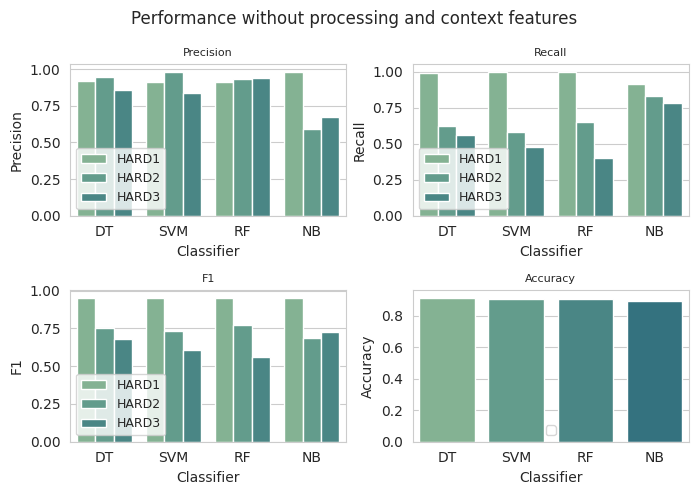

In [ ]:
plot_chart(np_context,'Performance without processing and context features')

<ipython-input-82-f8da1395b033>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Precision', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Recall', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='F1', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Accuracy', ci=None)


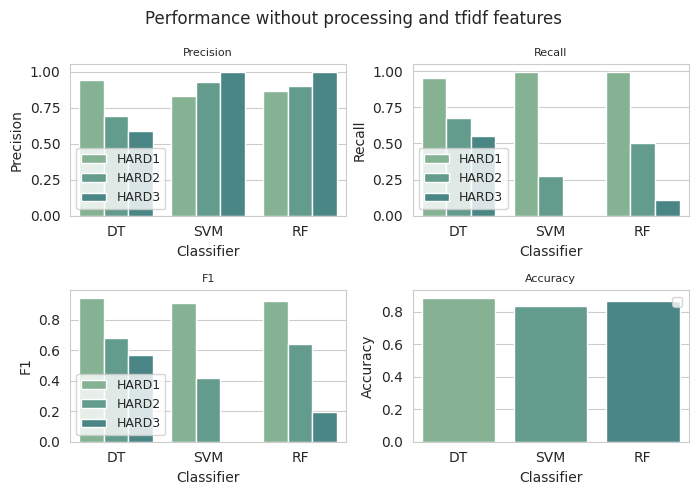

In [ ]:
plot_chart(np_tfidf,'Performance without processing and tfidf features')

<ipython-input-82-f8da1395b033>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Precision', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Recall', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='F1', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Accuracy', ci=None)


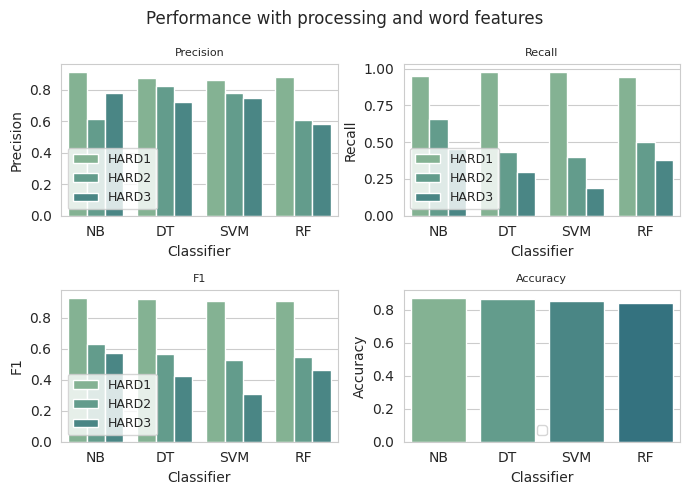

In [ ]:
plot_chart(wp_word,'Performance with processing and word features')

<ipython-input-82-f8da1395b033>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Precision', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Recall', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='F1', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Accuracy', ci=None)


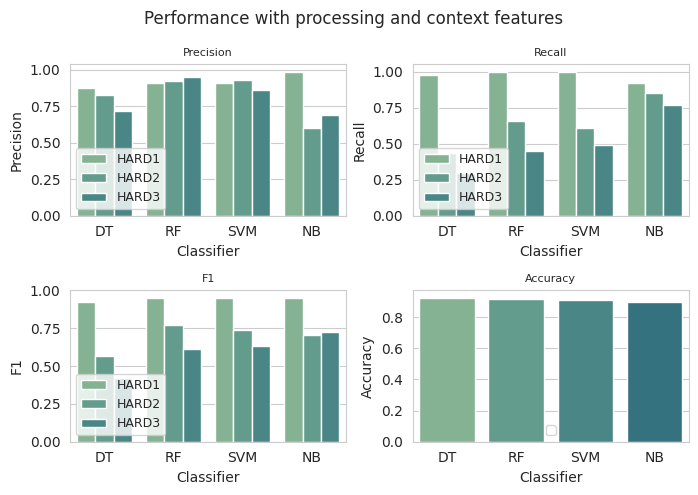

In [ ]:
plot_chart(wp_context,'Performance with processing and context features')

<ipython-input-82-f8da1395b033>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Precision', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Recall', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='F1', hue='Tag', ci=None)
<ipython-input-82-f8da1395b033>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='Classifier', y='Accuracy', ci=None)


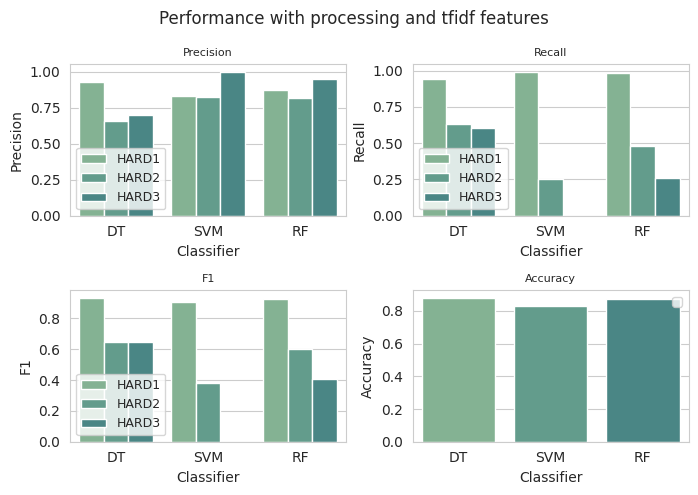

In [ ]:
plot_chart(wp_tfidf,'Performance with processing and tfidf features')

Text(0.5, 1.0, 'Accuracy - with pre-processing')

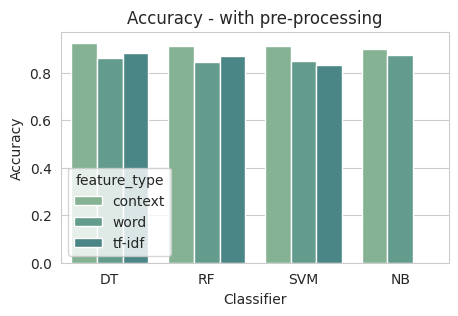

In [ ]:
plt.figure(figsize=(5, 3))
sns.barplot(wp, x="Classifier", y="Accuracy", hue="feature_type")
plt.title('Accuracy - with pre-processing')

Text(0.5, 1.0, 'Accuracy - without pre-processing')

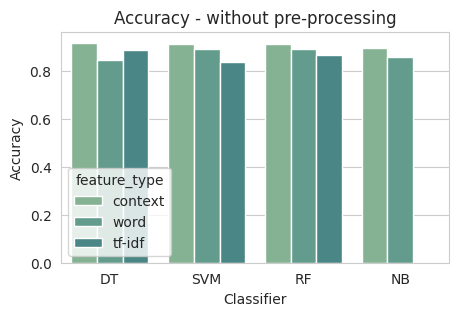

In [ ]:
plt.figure(figsize=(5, 3))
sns.barplot(np, x="Classifier", y="Accuracy", hue="feature_type")
plt.title('Accuracy - without pre-processing')

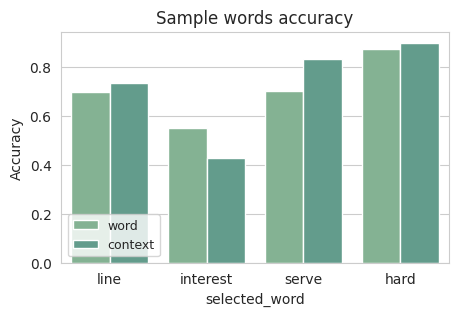

In [ ]:
#other samples from senseval

data = {
    'Classifier': ['NB', 'NB', 'NB', 'NB', 'NB', 'NB', 'NB', 'NB'],
    'Accuracy': [0.7, 0.7373, 0.55, 0.4283, 0.7009, 0.8345, 0.8743, 0.9008],
    'feature_type': ['word', 'context', 'word', 'context', 'word', 'context', 'word', 'context'],
    'selected_word': ['line', 'line', 'interest', 'interest', 'serve', 'serve', 'hard', 'hard'],
    'correct_pred': [581, 612, 262, 203, 614, 731, 758, 781],
    'total': [830, 830, 474, 474, 876, 876, 867, 867]
}

sample_words = pd.DataFrame(data)

plt.figure(figsize=(5, 3))
sns.barplot(sample_words, x="selected_word", y="Accuracy", hue="feature_type")
plt.title('Sample words accuracy')
plt.legend(fontsize=9,loc='lower left')


In [ ]:
##processing of csv and excel

def _transpose(l,classifier):
    l = l.transpose()

    rows_to_drop = ["macro avg", 'weighted avg','Unnamed: 0']
    l = l.drop(rows_to_drop)
    l = l.drop(l.columns[3], axis=1)

    new_column_names = {0: 'Precision', 1: 'Recall', 2: 'F1'}
    l = l.rename(columns=new_column_names)

    row = l.iloc[3]
    accu = row[0]

    rows_to_drop = ['accuracy']
    l = l.drop(rows_to_drop)

    l['Accuracy'] = accu
    l['feature_type'] = 'tf-idf'
    l['Classifier'] = classifier

    l_index = l.index
    l_i = list(l_index)
    l["Tag"] = l_i

    l = l.reset_index(drop=True)
    l = l[['Classifier', 'Tag', 'Precision', 'Recall', 'F1', 'Accuracy', 'feature_type']]

    return l


In [ ]:
a = pd.read_csv("DecisionTreeClassifier'_pre_1_2gram'.csv")
dt_pre = _transpose(a,'DT')

b = pd.read_csv("DecisionTreeClassifier'_without_pre_1_2gram'.csv")
dt_w_pre = _transpose(b,'DT')

In [ ]:
c = pd.read_csv("SVC'_pre_1_2gram'.csv")
svm_pre = _transpose(c,'SVM')

d = pd.read_csv("SVC'_without_pre_1_2gram'.csv")
svm_w_pre = _transpose(d,'SVM')

In [ ]:
e = pd.read_csv("RandomForestClassifier(random_state=42)'_pre_1_2gram'.csv")
rf_pre = _transpose(e,'RF')

f = pd.read_csv("RandomForestClassifier(random_state=42)'_without_pre_1_2gram'.csv")
rf_w_pre = _transpose(f,'RF')

In [ ]:
tfidf_pre = pd.concat([dt_pre, svm_pre,rf_pre])
tfidf_without_pre = pd.concat([dt_w_pre, svm_w_pre,rf_w_pre])

In [ ]:
tfidf_without_pre.to_excel("tfidf_without_pre.xlsx")
tfidf_pre.to_excel("tfidf_pre.xlsx")
